# On the importance of having the correct survey dimension and k-sampling for intensity mapping

`meer21cm` naturally deals with survey geometry, and therefore it is easier than most tools to have realistic forecasts of your desired signal with the correct
lightcone dimensions and sampling.

In particular, the clustering signal is anisotropic, due to signal properties such as RSD as well as observational effects such as the beam. Espeically for intensity mapping, where the transverse and line-of-sight direction have significantly different scales and resolutions, having the correct box lengths, grids, and therefore the correct k-sampling is crucial for forecasts.

If you want to forecast the measurements of some power spectrum statistics, we highly recommend that you 

- **use `meer21cm` to calculate the survey lightcone and k-modes**
- **build your model at the level of 3D k-space using your own tool** (since `meer21cm` only provides some simple model routine)
- **apply window convolution, observation effects either yourself or using `meer21cm`**
- **and finally average into the (usually 1D) statistics you want to use for forecasts**.

For this notebook, we will demonstrate the effect of simply having a non-cubic box and how important it is to have the correct k-modes at the 3D level.



## Survey set-up

Suppose you want to forecast for a MeerKLASS UHF-like survey, with ~7500 sqdeg for the southern patch from z-0.5 - 1.5:

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from meer21cm import util
from meer21cm.plot import plot_map
from meer21cm import PowerSpectrum

In [3]:
z_min = 0.5
z_max = 1.5
# frequency resolution in Hz, use your own number
freq_resol = 0.5e6
num_ch = int((util.redshift_to_freq(z_min)-util.redshift_to_freq(z_max))/freq_resol)
# obtain the frequency channels
nu = np.linspace(0,num_ch-1,num_ch) * freq_resol + util.redshift_to_freq(z_max)

In [27]:
ra_range = [-45, 80]
dec_range = [-70, 5]
ang_resol = 1.0 # in deg, similar to beam size here for simplicity
num_pix_x = 102 # one extra on each side as buffer
num_pix_y = 102 # one extra on each side as buffer
wcs, num_pix_x, num_pix_y = util.create_wcs_with_range(
    ra_range,
    dec_range,
    [ang_resol,ang_resol],
)

ps = PowerSpectrum(
    wproj=wcs,
    num_pix_x=num_pix_x,
    num_pix_y=num_pix_y,
    nu=nu,
    ra_range=ra_range,
    dec_range=dec_range,
)

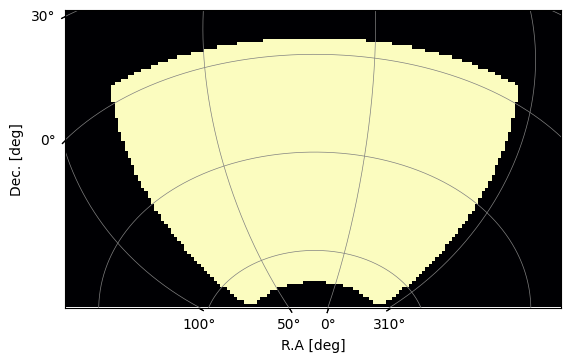

In [29]:
plot_map(ps.W_HI,ps.wproj,have_cbar=False)

In [30]:
print("total area of the survey is %.1f sqdeg" % (ps.W_HI[:,:,0].sum() * ps.pixel_area))
print("redshift range is %.1f - %.1f" % (ps.z_ch[-1], ps.z_ch[0]))

total area of the survey is 7349.0 sqdeg
redshift range is 0.5 - 1.5


## Box-dimensions and k-modes

You can then retrieve the lightcone dimensions very easily:

In [32]:
ps.get_enclosing_box()
ps.box_len

array([5745.6529501 , 7940.18852805, 3781.26218245])

Note that, the k-sampling also depends on your choice of grid resolution. Two factors come into play here: First, of course the grid resolution sets the Nyquist frequency of the k-grid; Second, the compensation effect of gridding is determined by the Nyquist frequency as well (see cookbook about gridding compensation). To ensure completeness in the sampling, it is typical to choose a resolution lower than the map pixel and channel resolution. This is controlled by these two parameters:

In [ ]:
# downscale the resolution along line-of-sight
ps.downres_factor_radial = 1.5
# downscale the resolution on the transverse plane
ps.downres_factor_transverse = 1.2
ps.get_enclosing_box()
# note how anisotropic the box is
ps.box_resol,ps.box_len

(array([66.04198793, 66.72427334,  5.00829428]),
 array([5745.6529501 , 7940.18852805, 3781.26218245]))

If you want a specific resolution in Mpc, you can check the pixel and channel resolution first and calculate these scaling factors:

In [ ]:
ps.pix_resol_in_mpc, ps.los_resol_in_mpc
# set scaling factor 
# ps.downres_factor_transverse = target_res_pix / ps.pix_resol_in_mpc
# ps.downres_factor_radial = target_res_los / ps.los_resol_in_mpc

(np.float64(55.55517205880652), np.float64(3.337730934154746))

Setting the box dimensions gives you the corresponding k-modes:

In [36]:
# |k| and \mu=k_para/|k|, with the 3D shape of the box
ps.kmode.shape,ps.mumode.shape, ps.k_nyquist

((87, 119, 378), (87, 119, 378), array([0.04702285, 0.04668755, 0.62644713]))

Given the k and mu mode, you can then propagate the model PS to the k-grids. Here we will just use a simple linear matter power spectrum with Kaiser RSD. You can take the k-values and mu-values to be input for your own model, and add in observational effects such as the beam etc (or use `meer21cm`, see other tutorials and here we focus on just highlighting the k-sampling) 

In [ ]:
power_model_3d = ps.auto_power_matter_model

Suppose you bin the monopole to 1D:

In [39]:
ps.k1dbins = np.linspace(0, 0.5, 21)
power_model_1d_1, keff, nmodes = ps.get_1d_power(power_model_3d)

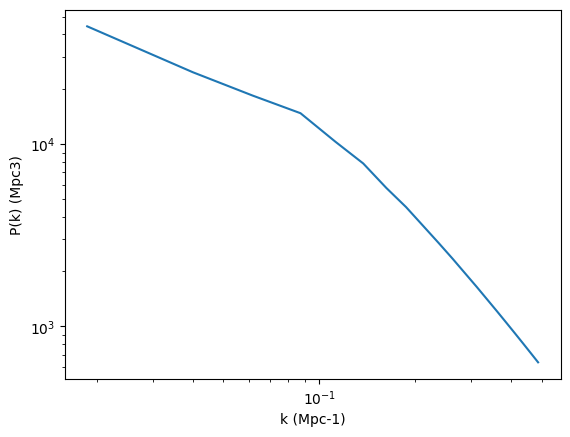

In [40]:
plt.plot(keff, power_model_1d_1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k (Mpc-1)")
plt.ylabel("P(k) (Mpc3)")
plt.show()

Now let's see what will happen if you naively use the survey volume and do a cubic box with some uniform k-sampling:

In [48]:
ps_temp = PowerSpectrum(
    wproj=ps.wproj,
    num_pix_x=ps.num_pix_x,
    num_pix_y=ps.num_pix_y,
    nu=ps.nu,
    ra_range=ps.ra_range,
    dec_range=ps.dec_range,
)
# cubic box with the same volume
ps_temp._box_len = np.ones(3) * np.prod(ps.box_len)**(1/3)
# same random grid resolution
ps_temp._box_ndim = np.array([400, 400, 400])
ps_temp.propagate_field_k_to_model()

ps_temp.k1dbins = np.linspace(0, 0.5, 21)
power_model_1d_2, keff2, nmodes2 = ps_temp.get_1d_power(ps_temp.auto_power_matter_model)

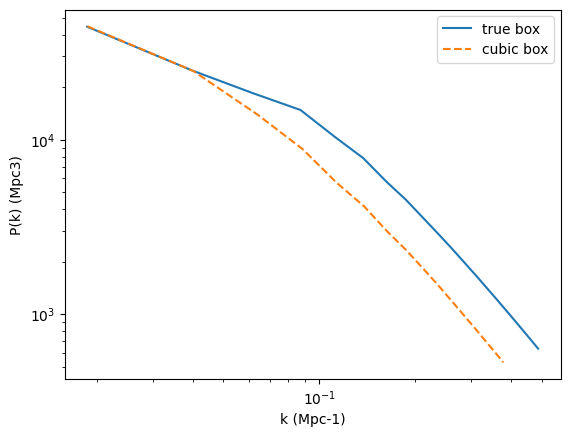

In [50]:
plt.plot(keff, power_model_1d_1,label='true box')
plt.plot(keff2, power_model_1d_2,label='cubic box',ls='--')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("k (Mpc-1)")
plt.ylabel("P(k) (Mpc3)")
plt.legend()

You can see that, even just for the matter power without any FoG, beam, etc, the effect of assuming the wrong k-sampling in your forecast will already be massive.